# Lecture 10 - Conjugate Priors; Online Update

In [8]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import textwrap

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

# Regularized Least Squares - Bayesian Interpretation

We showed that the regularized Least Squares problem:

$$J(\mathbf{w})= \frac{1}{2}\sum_{n=1}^N \left(t_n - y_n\right)^2 - \lambda \sum_{i=0}^M w_i^2$$

can be optimized directly by taking the derivative of $J(\mathbf{w})$ with respect to $\mathbf{w}$ and solve for $\mathbf{w}$.

The *Bayesian interpretation* gives that this problem is equivalent at maximizing the *posterior* distribution of the parameters $\mathbf{w}$ given the model prediction errors $\mathbf{e} = \mathbf{t}-\mathbf{y}$, that is:

\begin{align}
& \arg_{\mathbf{w}}\min \left(J(\mathbf{w})\right) \\
= & \arg_{\mathbf{w}}\max \left(\exp\left(- J(\mathbf{w})\right)\right) \\
=& \arg_{\mathbf{w}}\max \left(\prod_{n=1}^N \exp\left(-\frac{1}{2}\left(t_n - y_n\right)^2\right) \prod_{i=0}^M \exp \left(-\lambda w_i^2\right) \right)\\
\propto & \arg_{\mathbf{w}}\max p(\mathbf{e}|\mathbf{w}) p(\mathbf{w})\\
\propto & \arg_{\mathbf{w}}\max p(\mathbf{w}|\mathbf{e})
\end{align}

From this interpretation, we see that the:

1. The error variable $\mathbf{e}$ is distributed according to a Gaussian distribution, in particular, $\mathbf{e}\sim \mathcal{N}(0,1)$.
2. The prior distribution is equivalent at modeling a Gaussian distribution on the parameters $\mathbf{w}$, i.e., $\mathbf{w}\sim \mathcal{N}(0,1/\lambda)$
3. In practice, if the errors of our prediction should take some other distributional form, we can use the Bayesian interpretation to model the *data likelihood* and the *prior* with any known distributional form or use a density estimation function.

# Conjugate Priors

* Two distributions have a **conjugate prior** relationship when the form of the posterior is the same as the form of the prior.

    * For example, consider the data likelihood $P(X|\mu) \sim \mathcal{N}(\mu, \sigma^2)$ and the prior distribution $P(\mu) \sim \mathcal{N}(\mu_0,\sigma_0^2)$. The posterior probability will also be Gaussian distributed
    
$$P(\mu|X) \sim \mathcal{N}\left(\frac{\sum_{i=1}^N x_i\sigma_0^2 + \mu_0\sigma^2}{N\sigma_0^2+\sigma^2},\left(\frac{N}{\sigma^2}+\frac{1}{\sigma_0^2}\right)^{-1}\right)$$

<!-- Proof: 

\begin{align}
P(\mu|X) &\propto P(X|\mu)P(\mu) \\
& = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{1}{2}\frac{(x_i-\mu)^2}{\sigma^2}\right)\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(-\frac{1}{2}\frac{(\mu-\mu_0)^2}{\sigma_0^2}\right) \\
&=  \frac{1}{\sqrt{2\pi\sigma^2}}\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(\sum_{i=1}^N \left(-\frac{1}{2}\frac{(x_i-\mu)^2}{\sigma^2}\right) -\frac{1}{2}\frac{(\mu-\mu_0)^2}{\sigma_0^2} \right) \\
&=  \frac{1}{\sqrt{2\pi\sigma^2}}\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(-\frac{1}{2}\left(\sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2} +\frac{(\mu-\mu_0)^2}{\sigma_0^2} \right) \right) \\
&=  \frac{1}{\sqrt{2\pi\sigma^2}}\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(-\frac{1}{2}\left(\frac{\sum_{i=1}^N x_i^2-2\sum_{i=1}^N x_i\mu +\mu^2N)}{\sigma^2} +\frac{\mu^2-2\mu\mu_0 +\mu_0^2}{\sigma_0^2} \right) \right) \\
&=  \frac{1}{\sqrt{2\pi\sigma^2}}\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(-\frac{1}{2} \left(\frac{N}{\sigma^2}+\frac{1}{\sigma_0^2}\right) - 2\mu \left( \frac{\sum_{i=1}^N x_i}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}\right) + \frac{\sum_{i=1}^N x_i^2}{\sigma^2} + \frac{\mu_0^2}{\sigma_0^2}\right) \\
&=  \frac{1}{\sqrt{2\pi\sigma^2}}\frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(-\frac{1}{2} \left(\frac{N}{\sigma^2}+\frac{1}{\sigma_0^2}\right) \left(\mu^2 - 2\mu\left(\frac{\sum_{i=1}^N x_i}{\sigma^2} + \frac{\mu_0}{\sigma_0^2}\right)\left(\frac{N}{\sigma^2}+\frac{1}{\sigma_0^2}\right)^{-1} \right) \right) \exp\left(\frac{\sum_{i=1}^N x_i}{\sigma^2} + \frac{\mu_0^2}{\sigma_0^2}\right)
\end{align} -->

* There are many conjugate prior relationships, e.g., Bernoulli-Beta, Gausian-Gaussian, Gaussian-Inverse Wishart, Multinomial-Dirichlet.

* Conjugate prior relationships play an important role for online **updating** our prior distribution.

* In an online model estimation scenario, where we the posterior has the same form as the prior, we can use the posterior as our new prior. This new prior is now data informative and will update it's parameters based on (1) our initial choice, and (2) the data. 

## Conjugate Prior Relationship, Gaussian-Gaussian

For a D-dimensional Gaussian data likelihood with mean $\mu$ and covariance $\beta\mathbf{I}$ and a prior distribution with mean $\mu_0$ and covariance $\Sigma_0$

\begin{align}
P(\mathbf{e}|\mathbf{w}) &\sim \mathcal{N}(\mathbf{\mu}, \beta\mathbf{I}) \\
P(\mathbf{w}) &\sim \mathcal{N}(\mathbf{\mu}_0,\Sigma_0)
\end{align}

The posterior distribution

\begin{align}
P(\mathbf{w}|\mathbf{e}) &\sim \mathcal{N}\left(\mathbf{\mu}_N, \Sigma_N\right) \\
\mathbf{\mu}_N &= \Sigma_N \left(\Sigma_0^{-1}\mathbf{\mu}_0+\beta\mathbf{\Phi}^T\mathbf{t}\right)\\
\Sigma_N^{-1} &= \Sigma_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}
\end{align}

where $\mathbf{\Phi}$ is the matrix of features extracted from the data samples $\{x_i\}_{i=1}^N$. If we consider polynomial features, then $\mathbf{\phi}(\mathbf{x}_k) = \left[x_k^0, x_k^1, \cdots, x_k^M \right]$.

* What happens with different values of $\beta$ and $\Sigma_0$?

To simplify, let's assume $\Sigma_0 = \alpha^{-1}\mathbf{I}$ and $\mathbf{\mu}_0 = [0,0]$, thus 

$$\mu_N = \beta \Sigma_N\mathbf{\Phi}^T\mathbf{t}$$

and

$$\Sigma_N^{-1} = \left(\alpha^{-1}\mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} $$

### Example of Online Updating of the Prior using Conjugate Priors (Gaussian-Gaussian)

Let's consider the example presented in the Bishop textbook (Figure 3.7 in page 155).

Consider a single input variable $\mathbf{x}$, a single target variable $\mathbf{t}$ and a linear model of the form $y(\mathbf{x},\mathbf{w}) = w_0 + w_1\mathbf{x}$.
Because this has just two parameters coefficients, $w=[w_0, w_1]^T$, we can plot the prior and posterior distributions directly in parameter space (2-dimensional parameter space).

Let's generate some synthetic data from the function $f(x, a) = w_0 + w_1x$ with parameter values $w_0 = −0.3$ and $w_1 = 0.5$ by first choosing values of $x_n$ from the uniform distribution $U(x_n|−1, 1)$, then evaluating $f(x_n, \mathbf{w})$, and finally adding Gaussian noise with standard deviation of $\sigma = 0.2$ to obtain the target values $t_n$.

$$t_n = f(x_n, \mathbf{w}) + \epsilon = -0.3 + 0.5 x_n + \mathbf{\epsilon}$$

where $\mathbf{\epsilon}\sim \mathcal{N}(0,0.2^2\mathbf{I})$.

* **Our goal is to recover the values of $w_0$ and $w_1$ from such data, and we will explore the dependence on the size of the data set.**

For some data, $\{x_n,t_n\}_{n=1}^N$, we can pose this problem in terms of **Regularized Least Squares**:

\begin{align}
E(\mathbf{w}) &= \frac{1}{N} \sum_{n=1}^N \left(t_n - y_n\right)^2 + \lambda \sum_{i=0}^1 w_i^2 \\
&= \frac{1}{N} \sum_{n=1}^N \left(t_n - y_n\right)^2 + \lambda \left(w_0^2 + w_1^2\right)\\
& \Rightarrow \arg_{\mathbf{w}}\min J(\mathbf{w})
\end{align}

* Using **MAP**, we can rewrite our objective using the **Bayesian interpretation**:

\begin{align}
\arg_{\mathbf{w}} \max P(\mathbf{\epsilon}|\mathbf{w})P(\mathbf{w})
\end{align}

Let's consider the data likelihood, $P(\mathbf{\epsilon}|\mathbf{w})$, to be a Gaussian distribution with mean $\mu = 0$ and variance $\sigma^2 = 0.2^2$. And let's also consider the prior distribution, $P(\mathbf{w})$, to be a Gaussian distribution with mean $\mu_0$ and variance $\sigma_0^2$. Then, using the derivations from above, we can rewrite our optimization as:

\begin{align}
\arg_{\mathbf{w}} \max & \mathcal{N}(\mathbf{\epsilon}|0,\beta\mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{\mu_0} ,\alpha^{-1}\mathbf{I}) \\
\propto\arg_{\mathbf{w}} \max & \mathcal{N}\left( \beta \Sigma_N^{-1} \mathbf{\Phi}^T\mathbf{t}, \Sigma_N \right)
\end{align}

where $\mathbf{\mu}_0 = [0,0]$, $\mathbf{\Phi}$ is the polynomial feature matrix, and $\Sigma_N = \alpha^{-1}\mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi}$ is the covariance matrix of the posterior distribution.

Note that we **do not known** the parameters of the prior distribution ($\mu_0$ and $\sigma_0$ are unknown). The parameters of the prior distribution will have to be chosen by the user. And they will essentially *encode* any behavior or a priori knowledge we may have about the weights.

* **Both our data likelihood and prior distributions are in a 2-dimensional space (this is because our *model order* is $M=2$ -- we have 2 parameters!).**

We are going to generate data from $t = -0.3 + 0.5x + \epsilon$ where $\epsilon$ is drawn from a zero-mean Gaussin distribution.

* **The goal is to estimate the values $w_0=-0.3$ and $w_1=0.5$**
* The feature matrix $\mathbf{\Phi}$ can be computed using the polynomial basis functions
* **Parameters to choose:** $\beta$ and $\alpha$

We want to implement this scenario for a case that we are getting more data every minute. As we get more and more data, we want to **update our prior distribution using our posterior distribution (informative prior)**, because they take the have the same distribution form. This is only possible because because Gaussian-Gaussian have a conjugate prior relationship. That is, the posterior distribution is also a Gaussian.

In [31]:
def likelihood_prior_func(beta = 2, alpha = 1, draw_num=(0,1,10,20,50,100)):
    '''Online Update of the Posterior distribution for a Gaussian-Gaussian conjugate prior.
    Parameter:
    beta - variance of the data likelihood (of the additive noise)
    alpha - precision value or 1/variance of the prior distribution
    draw_num - number of points collected at each instance.
    
    This function will update the prior distribution as new data points are received.
    The prior distribution will be the posterior distribution from the last iteration.'''
    
    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    # true (unknown) weights
    a = -0.3 # w0
    b = 0.5  # w1
    
    # set up input space range
    rangeX = [-2, 2]
    step = 0.025
    X = np.mgrid[rangeX[0]:rangeX[1]:step]

    #initialize prior/posterior and sample data
    S0 = (1/alpha)*np.eye(2) # prior covariance matrix
    sigma = S0
    mean = [0,0]
    draws = np.random.uniform(rangeX[0],rangeX[1],size=draw_num[-1])
    T = a + b*draws + np.random.normal(loc=0, scale=math.sqrt(beta))

    for i in range(len(draw_num)):
        if draw_num[i]>0: #skip first image
            #Show data likelihood
            Phi = np.vstack((np.ones(draws[0:draw_num[i]].shape), draws[0:draw_num[i]])) #Polynomial features
            t = T[0:draw_num[i]]
            sigma = np.linalg.inv(S0 + beta*Phi@Phi.T)
            mean = beta*sigma@Phi@t

            w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
            p = multivariate_normal(t[draw_num[i]-1], beta)
            out = np.empty(w0.shape)
            for j in range(len(w0)):
                out[j] = p.pdf(w0[j]+w1[j]*draws[draw_num[i]-1])

            ax = fig.add_subplot(*[len(draw_num),3,(i)*3+1])
            ax.pcolor(w0, w1, out)
            ax.scatter(a,b, c='c')
            myTitle = 'data likelihood'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        #Show prior/posterior
        w0, w1 = np.mgrid[rangeX[0]:rangeX[1]:step, rangeX[0]:rangeX[1]:step]
        pos = np.empty(w1.shape + (2,))
        pos[:, :, 0] = w0; pos[:, :, 1] = w1
        p = multivariate_normal(mean, sigma)

        ax = fig.add_subplot(*[len(draw_num),3,(i)*3+2])
        ax.pcolor(w0, w1, p.pdf(pos))
        ax.scatter(a,b, c='c')
        myTitle = 'Prior/Posterior'
        ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

        #Show data space
        for j in range(6):
            w0, w1 = np.random.multivariate_normal(mean, sigma)
            t = w0 + w1*X
            ax = fig.add_subplot(*[len(draw_num),3,(i)*3+3])
            ax.plot(X,t)
            if draw_num[i] > 0:
                ax.scatter(Phi[1,:], T[0:draw_num[i]])
            myTitle = 'data space'
            ax.set_title("\n".join(textwrap.wrap(myTitle, 100)))

    plt.show()

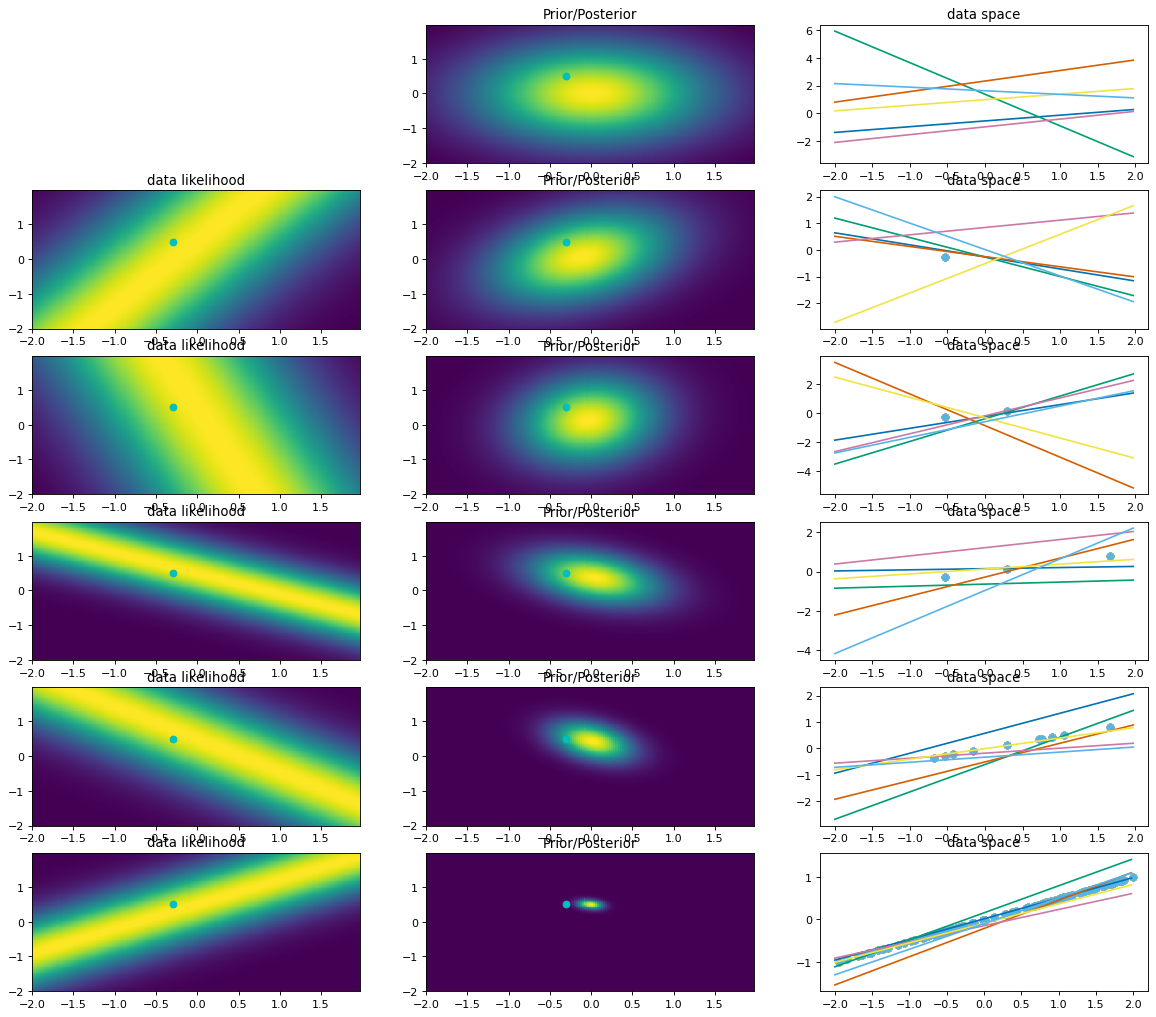

In [47]:
import warnings
warnings.filterwarnings('ignore')

# Parameters
# beta - variance of the data likelihood (of the additive noise)
# alpha - precision value or 1/variance of the prior distribution
# draw_num - number of points collected at each instance.

likelihood_prior_func(beta = 1, alpha = 1, draw_num=(0,1,2,3,10,100))